In [16]:
from functools import partial
import os

import pytorch_lightning as pl
from pytorch_lightning.plugins import DDPPlugin
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

from End2End.Data import DataModuleEnd2End, End2EndBatchDataPreprocessor
from End2End.tasks.separation import Separation
from End2End.tasks.transcription import Transcription
from End2End.tasks.t_separation import TSeparation

import End2End.models.separation as SeparationModel
import End2End.models.transcription.combined as TranscriptionModel

from End2End.MIDI_program_map import (
                                      MIDI_Class_NUM,
                                      MIDIClassName2class_idx,
                                      class_idx2MIDIClass,
                                      )
from End2End.data.augmentors import Augmentor
from End2End.lr_schedulers import get_lr_lambda
from End2End.losses import get_loss_function
import End2End.losses as Losses
import matplotlib.pyplot as plt

# Libraries related to hydra
import hydra
from hydra.utils import to_absolute_path
import torch
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
hydra.initialize(config_path="End2End/config/")
cfg = hydra.compose(config_name="tseparation")

/home/tiger/anaconda3/envs/jointist/lib/python3.8/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'tseparation': Defaults list is missing `_self_`. See https://hydra.cc/docs/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [31]:
r"""Train an instrument classification system, evluate, and save checkpoints.

Args:
    workspace: str, path
    config_yaml: str, path
    gpus: int
    mini_data: bool

Returns:
    None
"""


cfg.datamodule.waveform_hdf5s_dir = to_absolute_path(os.path.join('hdf5s', 'waveforms'))
checkpoint_path = to_absolute_path(cfg.checkpoint_path) 

cfg.MIDI_MAPPING.plugin_labels_num = MIDI_Class_NUM
cfg.MIDI_MAPPING.NAME_TO_IX = MIDIClassName2class_idx
cfg.MIDI_MAPPING.IX_TO_NAME = class_idx2MIDIClass
cfg.datamodule.notes_pkls_dir = to_absolute_path('instruments_classification_notes_MIDI_class/')         

experiment_name = (
                  f"Eval-TSeparation-"
                  f"{cfg.inst_sampler.samples}p{cfg.inst_sampler.neg_samples}n-"
                  f"ste_roll"
                  )

# augmentor
augmentor = Augmentor(augmentation=cfg.augmentation) if cfg.augmentation else None

# data module
data_module = DataModuleEnd2End(**cfg.datamodule,augmentor=augmentor, MIDI_MAPPING=cfg.MIDI_MAPPING)
data_module.setup('test')

lr_lambda = partial(get_lr_lambda, **cfg.scheduler.args)
    

Loading test pkl files: 100%|██████████| 225/225 [00:06<00:00, 32.27it/s] 


In [ ]:
batch = next(iter(data_module.test_dataloader()))
batch_idx = 0

In [27]:
output_dict = torch.load('./outputs/2022-03-09/15-29-28/audio_output/Track01876/Bass.pt')

In [23]:
output_dict['waveform'].shape

torch.Size([4143741])

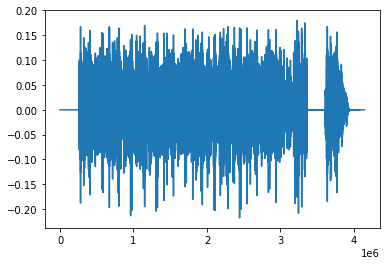

In [24]:
plt.plot(output_dict['waveform'])

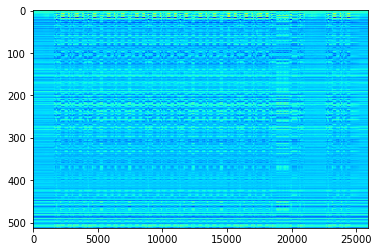

In [30]:
plt.imshow(output_dict['roll_feat'].t(), aspect='auto', cmap='jet')

In [6]:
_, _, output_dict = tseparation.transcription_model.test_step(batch,batch_idx, False, None)

In [7]:
plugin_ids = torch.where(batch['instruments'][0]==1)[0] 
conditions = torch.zeros((len(plugin_ids), 40), device=plugin_ids.device)
#         conditions.zero_()
conditions.scatter_(1, plugin_ids.view(-1,1), 1)    
trackname = batch['hdf5_name'][0]

In [8]:
conditions.shape

torch.Size([9, 40])

In [9]:
roll_dict = batch['target_dict'][0]

In [10]:
condition = conditions[0]

In [11]:
IX_TO_NAME = cfg.MIDI_MAPPING.IX_TO_NAME

In [17]:
seg_batch_size = cfg.separation.evaluation.seg_batch_size
segment_samples = cfg.segment_seconds*16000

In [13]:
# keys = {'Strings', 'Piano', ... 'Bass'}
roll = torch.from_numpy(roll_dict[IX_TO_NAME[condition.argmax().item()]]['frame_roll']) # (T, F)

In [ ]:
roll = roll.float().to(condition.device) # (1, T, F)
_output_dict = tseparation.separation_model._separate_fullaudio(batch['waveform'], condition, segment_samples, seg_batch_size, roll)   

In [ ]:
for idx, condition in enumerate(conditions):
    if self.test_segment_size!=None:
        # TODO: use a better condition rather than this dangerous one
        # since self.transcirption is always=True
        if roll_pred!=None:
            roll = roll_pred['frame_output'].squeeze(0)[:,idx*88:(idx+1)*88]
            # keys = {'Strings', 'Piano', ... 'Bass'}
            roll = roll.float().to(condition.device).unsqueeze(0) # (1, T, F)

            roll_dict = batch['target_dict'][0]
            target_roll = torch.from_numpy(roll_dict[self.IX_TO_NAME[condition.argmax().item()]]['frame_roll']) # (T, F)
            target_roll = target_roll.float().unsqueeze(0).to(condition.device) # (1, T, F)                       
#                     timesteps = min(target_roll.shape[1], roll.shape[1])

#                     frame_p, frame_r, frame_f1, _ = precision_recall_fscore_support(roll[0,:timesteps].cpu().flatten(),
#                                                                                     target_roll[0,:timesteps].cpu().flatten(),
#                                                                                     average='binary')     
#                     print(f"{frame_f1=}")
            _output_dict = self.network(batch['waveform'].unsqueeze(1), condition.unsqueeze(0), roll.float()) 
        elif self.transcription:
            roll_dict = batch['target_dict'][0]
            # keys = {'Strings', 'Piano', ... 'Bass'}
            roll = torch.from_numpy(roll_dict[self.IX_TO_NAME[condition.argmax().item()]]['frame_roll']) # (T, F)
            roll = roll.float().unsqueeze(0).to(condition.device) # (1, T, F)                    
            _output_dict = self.network(batch['waveform'].unsqueeze(1), condition.unsqueeze(0), roll.float())                   
        else:
            _output_dict = self.network(batch['waveform'].unsqueeze(1), condition.unsqueeze(0))
    else:
        if roll_pred!=None:
            roll = roll_pred['frame_output'][:,idx*88:(idx+1)*88]
            # keys = {'Strings', 'Piano', ... 'Bass'}
            roll = roll.float().to(condition.device) # (1, T, F)
            roll.unsqueeze(0)                                  
            _output_dict = self._separate_fullaudio(batch['waveform'], condition, self.segment_samples, self.seg_batch_size, roll)         
        elif self.transcription:
            roll_dict = batch['target_dict'][0]
            # keys = {'Strings', 'Piano', ... 'Bass'}
            roll = torch.from_numpy(roll_dict[self.IX_TO_NAME[condition.argmax().item()]]['frame_roll']) # (T, F)
            roll = roll.float().to(condition.device) # (1, T, F)
            _output_dict = self._separate_fullaudio(batch['waveform'], condition, self.segment_samples, self.seg_batch_size, roll)                  
        else:
            _output_dict = self._separate_fullaudio(batch['waveform'], condition, self.segment_samples, self.seg_batch_size)            
    pred = _output_dict['waveform'] # (len)

    plugin_type = self.IX_TO_NAME[plugin_ids[idx].item()]

    # adjust the output dim
    if pred.dim()==1:
        pred = pred.unsqueeze(0)
    elif pred.dim()==3:
        pred = pred.squeeze(1)

    if batch_idx==0:
        torchaudio.save(os.path.join(self.evaluation_output_path, batch['hdf5_name'][0],f"{plugin_type}.mp3"),
                        pred.cpu(),
                        16000)
    # calcuating and logging SDR
    # 1. convert numpy array into torch tensor
    label = torch.from_numpy(batch['sources'][0][plugin_type])
    # 2. make sure the source shape is (1, len)
    if label.dim()==1:
        label = label.unsqueeze(0)
    elif label.dim()==2:
        label = label
    else:
        raise ValueError(f"label shape = {label.shape}. Please make sure it is (1, len)")

    sdr = calculate_sdr(label, pred.cpu())
    logger.log('Separation/Test/sourcewise_SDR', sdr)
    sdr_dict[trackname][plugin_type] = sdr